## Quality Estimation notebook

This notebook encloses the preprocessing of MOCHA dataset referring to an initial experiment for Quality Estimation. It takes as input the original MOCHA files and unflattens each instance <c, q, ref, cand> (context, question, reference, and candidate) into two <c, q, a, s> instances (context, question, answer, human score). 

We produce two different files: 
- __all__: which assumes that reference answers are given 100% correctness scores.
- __candidates_only__: which contains only the candidates and the scores to them associated.

In [ ]:
import numpy as np

MOCHA_DIR_PATH = ".."
!ls {MOCHA_DIR_PATH}

In [ ]:
def write_to_file(data: dict, filename, output_dir):
    output_filepath = f"{output_dir}/{filename}.json"
    with open(output_filepath, 'w', encoding='utf-8') as f:
        json.dump(data, f, ensure_ascii=False)

In [ ]:
def flatten_ref_candidate(example: dict) -> tuple:
    """Flatten example in terms of ``reference`` and ``candidate`` answers.
    
    Returns
    -------
    2-dim tuple
        The data referring to the reference and candidate examples.
        Both data information shares the same context and question.
    """
    reference = {
        "question": example["question"],
        "context": example["context"],
        "answer": example["reference"],
        "is_reference": True,
        "correctness": 5, # assumption
        "correctness_std": 0,   # more realistic assumption could depend 
                                # on how many wrong answers we find in the data.
        "_metadata": str({}),
    }
    candidate = {
        "question": example["question"],
        "context": example["context"],
        "answer": example["candidate"],
        "is_reference": False,
        "correctness": example["score"],
        "correctness_std": np.std(example["metadata"]["scores"]),
        "_metadata": str(example["metadata"]),
    }
            
    return reference, candidate


def extend(examples: dict) -> tuple:
    """Computes the extended version of the examples."""
    extended_examples = {}
    extended_examples_cand_only = {}

    for example_id, example in examples.items():
        reference, candidate = flatten_ref_candidate(example)

        extended_examples[f"{example_id}__orig"] = reference 
        extended_examples[f"{example_id}__cand"] = candidate 
        extended_examples_cand_only[f"{example_id}"] = candidate 
    assert len(extended_examples) == len(extended_examples_cand_only) * 2
    
    return extended_examples, extended_examples_cand_only


# --------------------------------------------------------------
# Processing data
# --------------------------------------------------------------
def preprocess_data(filepath, out_name, output_dir):
    data = json.load(open(filepath))
    
    new_data = {}
    new_data_candidates_only = {}
    for dataset, examples in data.items():
        print(len(examples))
        ref_and_cand_examples, cand_examples = extend(examples)

        new_data[dataset] = ref_and_cand_examples
        new_data_candidates_only[dataset] = cand_examples
            
    
    write_to_file(new_data, f"{out_name}_all", output_dir=output_dir)
    write_to_file(new_data_candidates_only, f"{out_name}_candidates_only", output_dir=output_dir)
    
    return new_data, new_data_candidates_only

## Dump file

In [ ]:
OUTPUT_DIR = "/home/kat/Projects/PhD/qasper-experiments/eqqa/data/mocha_eqqa_data"

In [ ]:
# 31069 train examples if consider every dataset
new_data, new_data_candidates_only = preprocess_data(
    filepath=f'{MOCHA_DIR_PATH}/train.json',
    out_name="original__train",
    output_dir=OUTPUT_DIR,
);

In [ ]:
# 4009 dev examples if consider every dataset
preprocess_data(
    filepath=f'{MOCHA_DIR_PATH}/dev.json',
    out_name="original__dev",
    output_dir=OUTPUT_DIR,
);

 Since the test set does not have correctness "labels"
 we will use the development set as the test set and 
 we will randomly sample the training set


In [ ]:
def split_examples(examples, fraction, seed, replace=False):
    np_rand = np.random.default_rng(seed)

    # Number of examples to be part of split1 
    n_samples = int(len(examples)*fraction)
    
    # Subset of indices that will partake in the dev set
    ids = np_rand.choice(
        np.arange(len(examples)), n_samples, replace=replace)

    split1 = {}
    split2 = {}
    
    for i, (example_id, example) in enumerate(examples.items()):
        if i in ids:
            split1[example_id] = example
        else:
            split2[example_id] = example
            
    return split1, split2


def split_data(filepath, eval_fraction, outnames, output_dir, seed=129831):    
    np_rand = np.random.default_rng(seed)
    data = json.load(open(filepath))

    train = {}
    dev = {}

    for dataset, examples in data.items():
        dataset_dev_set, dataset_train_set = split_examples(
            examples, fraction=eval_fraction, seed=np_rand.integers(10**6), replace=False)

        train[dataset] = dataset_train_set
        dev[dataset] = dataset_dev_set

    write_to_file(train, outnames[0], output_dir=output_dir)
    write_to_file(dev, outnames[1], output_dir=output_dir)
    
    return train, dev

In [ ]:
split_data(
    filepath=f'{OUTPUT_DIR}/original__train_all.json',
    eval_fraction=0.2,
    outnames=("split__train_all","split__dev_all"),
    output_dir=OUTPUT_DIR,
);

In [ ]:
split_data(
    filepath=f'{OUTPUT_DIR}/original__train_candidates_only.json',
    eval_fraction=0.2,
    outnames=("split__train_candidates_only","split__dev_candidates_only"),
    output_dir=OUTPUT_DIR,
);

## Check MOCHA dataset statistics 

In [8]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import json
import seaborn as sns

In [14]:
def load_dataset(filepath):
    data = json.load(open(filepath))

    all_datasets_df = []
    for dataset_name, dataset_examples in data.items():

        examples_to_df = []
        for example_id, example in dataset_examples.items():
            example["dataset"] = dataset_name
            example["example_id"] = example_id        
            examples_to_df.append(example)

        df = pd.DataFrame(examples_to_df)
        all_datasets_df.append(df)


    data = pd.concat(all_datasets_df).reset_index(drop=True)
    return data


train_data = load_dataset("../data/mocha_eqqa_data/split__train_all.json")
dev_data = load_dataset("../data/mocha_eqqa_data/split__dev_all.json")
test_data = load_dataset("../data/mocha_eqqa_data/original__dev_all.json")
print("Length of training and dev datasets (including both ref and candidate scores):", len(train_data), len(dev_data), len(test_data))


train_cand_data = load_dataset("../data/mocha_eqqa_data/split__train_candidates_only.json")
dev_cand_data = load_dataset("../data/mocha_eqqa_data/split__dev_candidates_only.json")
test_cand_data = load_dataset("../data/mocha_eqqa_data/original__dev_candidates_only.json")
print("Length of training and dev candidates only:", len(train_cand_data), len(dev_cand_data), len(test_cand_data))

Length of training and dev datasets (including both ref and candidate scores): 49713 12425 8018
Length of training and dev candidates only: 24858 6211 4009


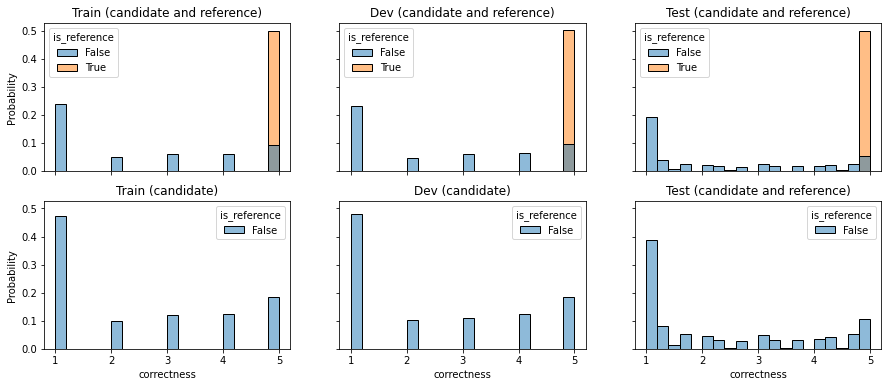

In [21]:
fig, axes = plt.subplots(2, 3, sharex=True, sharey=True, figsize=(15, 6))
hist_kwargs = {"x":"correctness", "bins": 20, "stat": "probability", "hue": "is_reference"}

ax = axes[0, 0]
ax.set_title("Train (candidate and reference)")
sns.histplot(train_data, ax=ax, **hist_kwargs);

ax = axes[0, 1]
ax.set_title("Dev (candidate and reference)")
sns.histplot(dev_data, ax=ax, **hist_kwargs);

ax = axes[0, 2]
ax.set_title("Test (candidate and reference)")
sns.histplot(test_data, ax=ax, **hist_kwargs);

ax = axes[1, 0]
ax.set_title("Train (candidate)")
sns.histplot(train_cand_data, ax=ax, **hist_kwargs);

ax = axes[1, 1]
ax.set_title("Dev (candidate)")
sns.histplot(dev_cand_data, ax=ax, **hist_kwargs);

ax = axes[1, 2]
ax.set_title("Test (candidate and reference)")
sns.histplot(test_cand_data, ax=ax, **hist_kwargs);

/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/seaborn/distributions.py:461: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges, name="edges"),
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/seaborn/distributions.py:462: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(widths, name="widths"),
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/seaborn/distributions.py:461: FutureWarning: In a future version, the Index constructor will not infer numeric dtypes when passed object-dtype sequences (matching Series behavior)
  pd.Index(edges, name="edges"),
/home/kat/miniconda3/envs/eqqa-env/lib/python3.9/site-packages/seaborn/distributions.py:462: FutureWarning: In a future version, the Index constructor will not infer nume

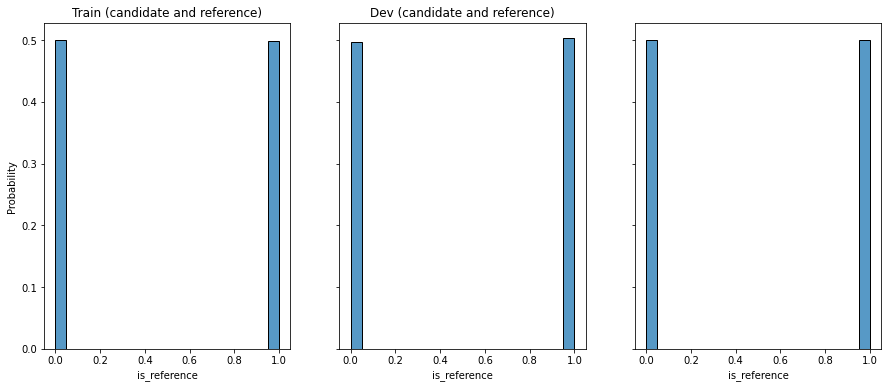

In [16]:
fig, axes = plt.subplots(1, 3, sharex=True, sharey=True, figsize=(15, 6))

hist_kwargs = {"bins": 20, "stat": "probability"}

ax = axes[0]
ax.set_title("Train (candidate and reference)")
sns.histplot(train_data["is_reference"], ax=ax, **hist_kwargs);

ax = axes[1]
ax.set_title("Dev (candidate and reference)")
sns.histplot(dev_data["is_reference"], ax=ax, **hist_kwargs);

ax = axes[2]
sns.histplot(test_data["is_reference"], ax=ax, **hist_kwargs);


In [17]:
train_data

,question,context,answer,is_reference,correctness,correctness_std,_metadata,dataset,example_id
0,What's a possible reason the guy stares into t...,"Somewhere in me I knew it all along , there ar...",Because he likes her a lot .,True,5,0.0,{},cosmosqa,002b5d9aa346d492b02705ae2c9f4abd__orig
1,What's a possible reason the guy stares into t...,"Somewhere in me I knew it all along , there ar...",He's a child and it's a very rare thing.,False,1,0.0,"{'scores': [1], 'source': 'gpt2'}",cosmosqa,002b5d9aa346d492b02705ae2c9f4abd__cand
2,What might be different if the friend didn't g...,Her dog and another kitten kept trying to esca...,Two of the kittens wouldn't have been killed,True,5,0.0,{},cosmosqa,00336fecc378c067330935b63ce0351d__orig
3,What may be your reason for leaving the Malays...,I know because some of the things learnt in Mo...,It didn't offer an accurate representation of ...,True,5,0.0,{},cosmosqa,003950650438f8a6446095e8f7c8e0bd__orig
4,What may be your reason for leaving the Malays...,I know because some of the things learnt in Mo...,it does not have a clear idea about culture in...,False,3,0.0,"{'scores': [3], 'source': 'backtranslation'}",cosmosqa,003950650438f8a6446095e8f7c8e0bd__cand
...,...,...,...,...,...,...,...,...,...
49708,How would you describe Jesse?,Jesse ate their cereal and didn't leave any fo...,selfish,True,5,0.0,{},socialiqa,fffb5bf0cbb536ab6a767396015ac98b__orig
49709,How would you describe Jesse?,Jesse ate their cereal and didn't leave any fo...,confident,False,1,0.0,"{'scores': [1], 'source': 'gpt2'}",socialiqa,fffb5bf0cbb536ab6a767396015ac98b__cand
49710,What does Addison need to do before this?,Addison was looking for their teddy bear. Addi...,have a stuffed bear,True,5,0.0,{},socialiqa,fffc03fc5f061ad5cc913108eef37ae4__orig
49711,What does Addison need to do before this?,Addison was looking for their teddy bear. Addi...,have their teddy bear lying there,False,3,0.0,"{'scores': [3], 'source': 'gpt2'}",socialiqa,fffc03fc5f061ad5cc913108eef37ae4__cand


In [13]:
df

NameError: name 'df' is not defined

In [ ]:
pd.DataFrame([example, example])